In [8]:
import sys
sys.path.insert(1, '/scratch/gpfs/ls1546/icl_experiments/')

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import embedding
import transformer
import dataset_utils
from tqdm.auto import tqdm

In [10]:
#load MNIST
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
train_data = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
test_data = datasets.MNIST('../data', train=False,
                    transform=transform)

In [11]:
#augment MNIST with multiple tasks
n_tasks = 4
# task_gen = dataset_utils.RandomTasks(train_data, num_tasks=n_tasks)

# these will be the num of seeds we send into get_transformed_batch

In [21]:
batch_size = 32
lr = 3e-4
momentum = 0.9
steps = 2000
log_freq = 100
device = 'cuda'
seq_len = 50 #this is what we previously called "batch_size"

In [22]:
#instantiate model
model = transformer.ImageICLTransformer(d_model=64,device='cuda',block_size=100)
print(model)

using flash attention
Embedding Transformer with 816332 parameters, 210360 parameters in embedder & 604682 parameters in transformer


In [ ]:
#train the model to do MNIST classification

model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])

loss_history = [0]*steps
model.train()
data_avg_t = 0
loss_avg_t = 0

# here, our "batch_size" is actually the sequence length since we want to draw seq_length samples from the dataset, and then transform them batch_num times, where each transformation is a different task
# the batch should have shape: (batch_size,seq_len,1,28,28),
# right now it has shape: (seq_len,1,28,28), and we will add in the batch dimension in the loop below
trainloader = torch.utils.data.DataLoader(train_data, batch_size=seq_len, shuffle=True)

# for step in tqdm(range(steps)):
step = 0
task_list = []
for images, labels in tqdm(trainloader):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    # images, labels = task_gen.get_batch(batch_size,seq_len=seq_len,device=device)
    
    # add batch dimension
    images = torch.unsqueeze(images, 0).to(device)
    labels = torch.unsqueeze(labels, 0).to(device)
    # transform a batch, using a randomly selected task num from our list of n_tasks for each sequence in the batch, concatenated along the batch dimension
    for i in range(batch_size):
        if i == 0:
            temp_images, temp_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
        else:
            temp2_images, temp2_labels, curr_seed = dataset_utils.get_transformed_batch(images, labels, seed=np.random.randint(n_tasks))
            temp_images = torch.cat((temp_images, temp2_images), 0)
            temp_labels = torch.cat((temp_labels, temp2_labels), 0)
        task_list.append(curr_seed)
    end.record()
    torch.cuda.synchronize()
    data_avg_t += start.elapsed_time(end)
    images = temp_images
    labels = temp_labels
    del temp_images, temp_labels, temp2_images, temp2_labels

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    start.record()
    optimizer.zero_grad()
    outputs = model((images,labels))
    pred = outputs[:,-1,:]
    loss = criterion(pred,labels[:,-1])
    loss.backward()
    optimizer.step()
    end.record()
    torch.cuda.synchronize()
    loss_avg_t += start.elapsed_time(end)
    loss_history[step] = loss.item()
    step += 1


DATA:  65.1973004875183
LOSS:  132.05138735198975


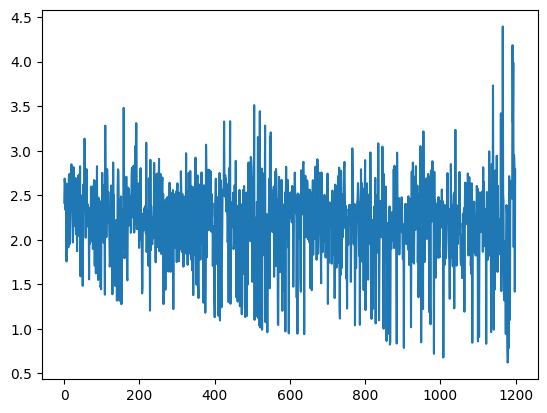

In [24]:
loss_history = np.array(loss_history)[:step]
plt.plot(loss_history)
print("\nDATA: ", data_avg_t/steps)
print("LOSS: ", loss_avg_t/steps)

In [ ]:
def test_model(model, task_generator, batch_size=32, seq_len=50, num_batch=50, device='cuda'):
    correct = 0
    model.eval()
    for batch in tqdm(range(num_batch)):
        images, labels = task_generator.get_batch(batch_size,seq_len=seq_len,device=device)
        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        _, predicted = torch.max(pred, 1)
        correct += (predicted == labels[:,-1]).sum()
    accuracy = 100 * (correct.item()) / (batch_size*num_batch)
    print(correct.item())
    print(accuracy)

In [ ]:
test_task_gen = dataset_utils.RandomTasks(test_data, num_tasks=n_tasks)
test_model(model, test_task_gen, batch_size=32, num_batch=50, seq_len=seq_len)

1875it [02:50, 10.98it/s]


2.3932494183381396


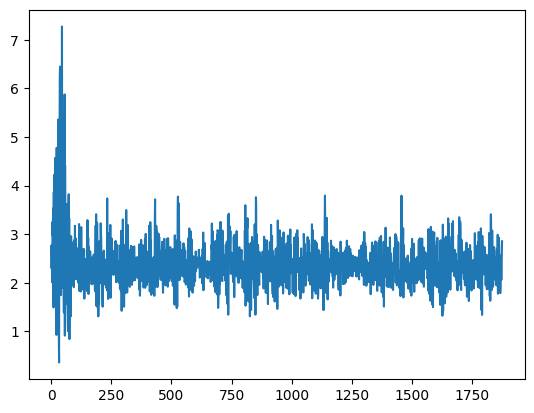

In [5]:
from tqdm import tqdm
#train the model to do MNIST classification

batch_size = 32
lr = 0.01
momentum = 0.9
epochs = 1
log_freq = 100
device = 'cuda'

model = model.to(device)

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = torch.nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50])

loss_history = []
seeds = []
for epoch in range(epochs):
    model.train()
    epoch_loss = [0]*(len(train_data)//batch_size)
    for i, (images, labels) in tqdm(enumerate(train_loader)):
        images, labels = images.to(device), labels.to(device)
        # apply transform
        aug_images, aug_labels, seed = dataset_utils.get_transformed_batch(images, labels, seed=i)
        seeds.append(seed)
        optimizer.zero_grad()
        images = aug_images.unsqueeze(1)
        labels = aug_labels.unsqueeze(1)
        B,T,C,W,H = images.shape
        images = images.reshape(T,B,C,W,H) #hack for now -- make batch dimension into sequence
        labels = labels.reshape(T,B)
        outputs = model((images,labels))
        pred = outputs[:,-1,:]
        loss = criterion(pred,labels[:,-1])
        loss.backward()
        optimizer.step()
        epoch_loss[i] = loss.item()

    lr_scheduler.step()
    loss_history += epoch_loss
    epoch_loss = np.array(epoch_loss)
    print(epoch_loss.mean())

loss_history = np.array(loss_history)
plt.plot(loss_history);

In [8]:
def test_model(model, dataset, batch_size=150, device='cuda'):
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    correct = 0
    model.eval()
    for i,(images, labels) in tqdm(enumerate(loader)):
        images, labels = images.to(device), labels.to(device)
        # apply transform
        images, labels, seed = dataset_utils.get_transformed_batch(images, labels, seed=i)
        images = images.unsqueeze(1)
        labels = labels.unsqueeze(1)
        outputs = model((images,labels))
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum()
    accuracy = 100 * (correct.item()) / len(dataset)
    print(accuracy)

In [10]:
test_model(model, test_data) #80% test accuracy

0it [00:00, ?it/s]

67it [00:02, 24.44it/s]

98.0
